In [1]:
### Import packages and define functions

import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geopandas as gpd
from matplotlib import colors
from scipy.spatial import cKDTree
from numpy.polynomial import Polynomial as P
import matplotlib.cm as cm
import pysymlog as psl
psl.register_mpl()

# local modules
sys.path.append((os.path.relpath(r"C:\Users\Chris\Box\Rutgers Stuff\Research\EM_ERI Calibration Paper\EConflux\code")))
import er2em
import em2er
import vse

from resipy import Project

def direct_local_grid_to_utm_along_line(local_grid_df, coord_list, polyDeg=3, numSamples=1000, lineLength=95, correctCoords=False, checkLine=False, saveElec=False, elecPath=None):
    
    if (max(coord_list['x']) - min(coord_list['x'])) > (max(coord_list['y']) - min(coord_list['y'])):
        func = P.fit(coord_list['x'], coord_list['y'], polyDeg)
        xx, yy = func.linspace(len(coord_list))
        sampX, sampY = func.linspace(numSamples)
        if checkLine:
            plt.plot(coord_list['x'], coord_list['y'], 'o', label='Original Points')
            plt.plot(xx, yy, lw=2, label='Interpolated Line')
            plt.gca().set_aspect('equal')
            plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
            plt.show()
            plt.close()
    else:
        func = P.fit(coord_list['y'], coord_list['x'], polyDeg)
        yy, xx = func.linspace(len(coord_list))
        sampY, sampX = func.linspace(numSamples)
        if checkLine:
            plt.plot(coord_list['y'], coord_list['x'], 'o', label='Original Points')
            plt.plot(yy, xx, lw=2, label='Interpolated Line')
            plt.gca().set_aspect('equal')
            plt.legend(loc='upper right', bbox_to_anchor=(1, 1.6))
            plt.show()
            plt.close()
    
    if correctCoords:
        coord_list['x'], coord_list['y'] = xx, yy
    
    linePos = np.zeros(numSamples)
    linePos = np.sqrt((sampX**2)+(sampY**2))
    if linePos[0] > linePos[-1]:
        relLinePos = abs((linePos - max(linePos)) / (max(linePos)-min(linePos)))
    else:
        relLinePos = (linePos - min(linePos)) / (max(linePos)-min(linePos))
    relLinePos *= lineLength
    
    elecDf = pd.DataFrame(np.transpose([relLinePos, np.zeros(numSamples)]), columns=['x', 'z'])
    
    tree = cKDTree(elecDf[['x', 'z']])
    dist, idx = tree.query(local_grid_df[['X', 'Z']])

    for i in range(0, len(local_grid_df)):
        local_grid_df.loc[i, ['x', 'y']] = [sampX[idx[i]], sampY[idx[i]]]

    if saveElec:
        coord_list.to_csv(elecPath + 'corrElecCoords.csv', index=False)
        
    return local_grid_df

def interpolate_nans(x, z, values):
    nan_mask = np.isnan(values)
    if np.any(nan_mask):  
        valid_points = ~nan_mask
        points = np.column_stack((x[valid_points], z[valid_points]))  
        values_known = values[valid_points]  
        values[nan_mask] = griddata(points, values_known, (x[nan_mask], z[nan_mask]), method='cubic')
        if np.any(np.isnan(values)):  
            values[nan_mask] = griddata(points, values_known, (x[nan_mask], z[nan_mask]), method='cubic')
    return values

# Function to generate contour plot
def plot_contour(ax, x, z, values, vmin, vmax, title=None, xmin=None, xmax=None, cbbool=True, dist=True, cmap='plasma', cbTicks=None, cbLabel=None, ri=None, riThresh=None, zbounds=None, numZtick=5, subfig=None, subfig2=None, contourOrSmooth='smooth', plotMeas=False, measPoints=None):

        grid_x = np.linspace(x.min(), x.max(), 200)
        grid_z = np.geomspace(z.min(), z.max(), 200)
        grid_X, grid_Z = np.meshgrid(grid_x, grid_z)
    
        grid_values = griddata((x, z), values, (grid_X, grid_Z), method='linear')
        
        if ri is not None:
            
            grid_mask = griddata((x, z), ri, (grid_X, grid_Z), method='linear')
    
            if 'DOI Flag' in ri.name:
                grid_mask = np.round(grid_mask)
                grid_mask = np.ma.masked_where(grid_mask > 0, grid_mask)
            else:
                grid_mask = np.ma.masked_where(grid_mask >  riThresh, grid_mask)
            
            grid_values = np.ma.masked_where(grid_mask.mask, grid_values)
    
        if contourOrSmooth == 'contour':
            contour = ax.contourf(grid_X, grid_Z, grid_values, norm=colors.LogNorm(vmin=vmin, vmax=vmax), levels=np.geomspace(vmin, vmax, 40), cmap=cmap)
        elif contourOrSmooth == 'smooth':
            contour = ax.pcolormesh(grid_X, grid_Z, grid_values, norm=colors.LogNorm(vmin=vmin, vmax=vmax), shading='gouraud', cmap=cmap)
       
        # Add scatter points on top of contour
        if plotMeas:
            if measPoints is not None:
                ax.scatter(measPoints.iloc[:, 0], measPoints.iloc[:, 1], color='white', edgecolor='black', s=0.05, zorder=10, label='Measurement Locations')
            else:
                ax.scatter(x, -1*z, color='white', edgecolor='black', s=0.05, zorder=10, label='Measurement Locations')
            ax.legend()
    
        if cbbool:
            cbar = plt.colorbar(contour, ax=ax, location='bottom', aspect=25, fraction=0.15, pad=0.3)
            if cbLabel is not None:
                cbar.set_label(cbLabel, fontsize=20, fontweight='bold')
            else:
                cbar.set_label(values.name, fontsize=20, fontweight='bold')
                
            if cbTicks is not None:
                cbar.set_ticks(cbTicks)
                cbar.set_ticklabels([str(t) for t in cbTicks])  # Format as strings
                cbar.ax.tick_params(labelsize=18)
        ax.set_xlabel('Distance Along ERI Line (m)' if dist else 'Length (m)', fontsize = 25, fontweight='bold')
        ax.set_ylabel('Depth (m)', fontsize = 25, fontweight='bold')
        if title is not None:
            ax.set_title(title, fontsize = 25, pad=30)
        if zbounds is not None:
            ax.set_ylim(zbounds[0], zbounds[1])
            ax.set_yticks(np.linspace(zbounds[0], zbounds[1], numZtick))
        else:
            ax.set_ylim(0, z.max())
            ax.set_yticks(np.linspace(0, z.max(), numZtick))
        ax.invert_yaxis()
        if subfig:
            ax.annotate(subfig, xy=(0.005, 1.1), xycoords="axes fraction", fontsize=20, color='black', bbox=dict(facecolor="white", alpha=0.8, edgecolor='black'))
        if subfig2:
            ax.annotate(subfig2, xy=(0.038, 1.09), xycoords="axes fraction", fontsize=20, color='black')
        if (xmin is not None) & (xmax is not None):
            ax.set_xlim(xmin, xmax)  
        ax.tick_params(axis='both', which='major', labelsize=20)
            # Make border (spines) thicker
        for spine in ax.spines.values():
            spine.set_linewidth(2.0)
        return grid_values


API path =  C:\Users\Chris\miniconda3\envs\geophysics\Lib\site-packages\resipy
ResIPy version =  3.6.6
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [2]:
### Define font properties

titleFontKws = {
    'fontsize': 16,
    'fontweight': 'bold',
    }

subtitleFontKws = {
    'fontsize': 12,
    'fontweight': 'bold',
    }

labelFontKws = {
    'fontsize': 14,
    'fontweight': 'bold',
    }

tickLabelFontKws = {
    'labelsize': 10,
    }

cbarTitleKws = {
    'fontsize': 14,
    'fontweight': 'bold'}

cbarTickKws = {
    'fontsize': 12,
    }

In [6]:
datDir = r"C:\Users\Chris\Box\Rutgers Stuff\Research\EM_ERI Calibration Paper\EConflux\examples\va_ag_em2er\\"

ertname = "va_ag_041425_filter.csv"

elecname = "va_ag_elec_resipy.csv"

eminame = "va_ag_MH_paraview_nocal_inph.csv"

Working directory is: C:\Users\Chris\Box\Rutgers Stuff\Research\EM_ERI Calibration Paper\EConflux\examples\va_ag_em2er
clearing dirname
Project created!
filterData: 0 / 3929 quadrupoles removed.
2552/3929 reciprocal measurements found.
0 measurements error > 20 %
9 measurements outside [0,150] removed!
filterData: 0 / 3920 quadrupoles removed.
0 measurements with greater than 5.0% reciprocal error removed!
filterData: 0 / 3920 quadrupoles removed.
0 measurements with greater than 5.0% stacking error removed!


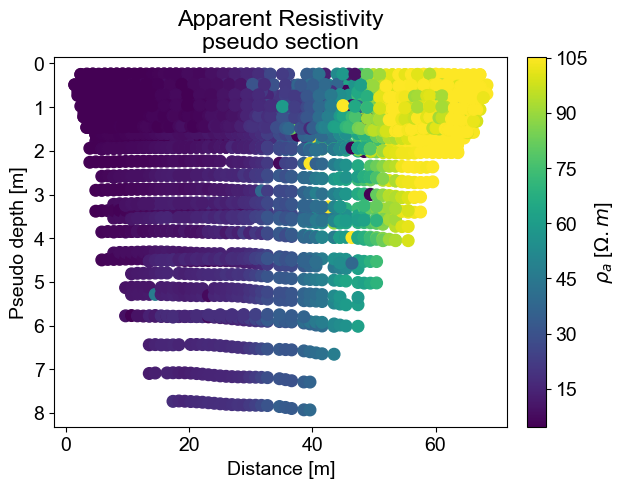

In [7]:
coordCrs = 32618  # Coordinate Reference System for georeferenced coordinates. Find yours here: https://epsg.io/

k = Project(typ = 'R2', dirname = datDir) 
k.createSurvey(datDir + ertname, ftype = 'Syscal')
k.importElec(datDir + elecname)
k.filterAppResist(vmin=0, vmax=150)
k.filterRecip(5)
k.filterStack(5)
elecUTM = k.elec.copy(deep=True)

elecdf = k.elec.copy(deep=True)
elecdf['X'] = np.zeros(len(elecdf))
elecGpd = gpd.GeoDataFrame(elecdf, geometry=gpd.points_from_xy(elecdf['x'], elecdf['y']), crs=coordCrs)
start = elecGpd.loc[elecGpd['elec'] == elecGpd['elec'].min()]
startPt = start['geometry']
for i in range(1, len(elecdf)):
    elecGpd.loc[i, 'X'] = elecGpd.loc[i-1, 'X'] + elecGpd.loc[i-1, 'geometry'].distance(elecGpd.loc[i, 'geometry'])
    
k.elec['x'] = elecGpd['X']
k.elec['y'] = np.zeros(len(k.elec))

k.showPseudo()

Creating triangular mesh...done (31969 elements)


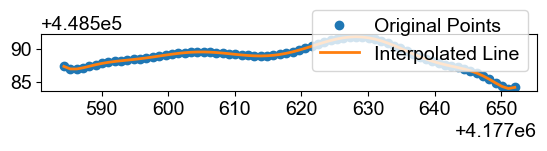

,param,elm_id,region,cellType,X,Y,Z,res0,phase0,zones,iter,x,y
0,1,1,1,5.0,62.349802,0.0,-12.500461,22.713434,0.0,1,0.0,448591.778300,4.177628e+06
1,2,2,1,5.0,32.181018,0.0,-11.333556,22.713434,0.0,1,0.0,448589.435612,4.177607e+06
2,3,3,1,5.0,-94.410008,0.0,-43.687251,22.713434,0.0,1,0.0,448587.330348,4.177584e+06
3,4,4,1,5.0,152.661938,0.0,-86.173646,22.713434,0.0,1,0.0,448584.182600,4.177652e+06
4,5,5,1,5.0,279.935312,0.0,-86.243048,22.713434,0.0,1,0.0,448584.182600,4.177652e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31964,31965,31965,1,5.0,65.928266,0.0,-3.471267,40.583203,0.0,1,0.0,448591.523762,4.177631e+06
31965,31966,31966,1,5.0,19.969063,0.0,-3.364379,8.341993,0.0,1,0.0,448588.843598,4.177598e+06
31966,31967,31967,1,5.0,23.997606,0.0,-3.228525,10.747946,0.0,1,0.0,448589.242920,4.177601e+06
31967,31968,31968,1,5.0,18.818522,0.0,-1.506934,6.304743,0.0,1,0.0,448588.723449,4.177598e+06


In [8]:
k.createMesh()

meshup = em2er.em2er_map(
    k=k,
    elecUTM=elecUTM,
    emicsv=datDir + eminame,
    linearOrPoly = 'Poly',
    alphaomega=(0, 71),
    polydeg = 10,
    mapvars=dict(num_neighbors=2, max_distance_xy=5, max_distance_z=0.2, ckdMethod='num'),
    fillstrat="mean",
    emires_col="_Linear Resistivity_arith"
)

out = meshup.run()

k.mesh.df

Doing error modelling...
Making temporary error modelling directory...
Running R* code (forward mode)...


 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 14 - 12 - 2025
 >> My beautiful survey                                                             
 >> F o r w a r d   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from resistivity.dat               

 Measurements read:  3920     Measurements rejected:     0

 >> Total Memory required is:          0.012 Gb
Adding to modelling error to data structures...
Modelling error done!
done
Writing .in file and protocol.dat... done

--------------------- MAIN INVERSION ------------------


 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 14 - 12 - 2025
 >> My beautiful survey                                                     

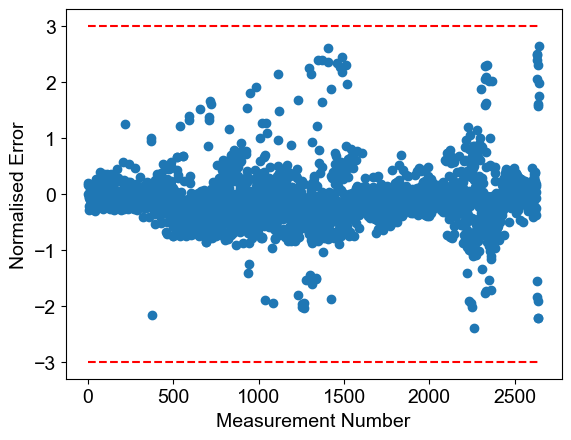

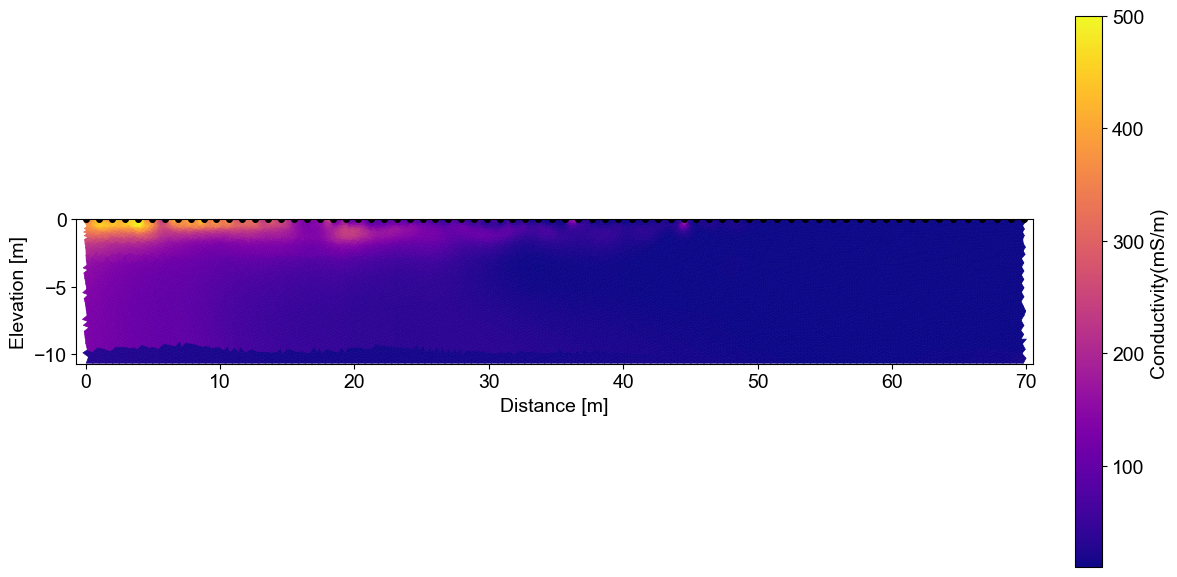

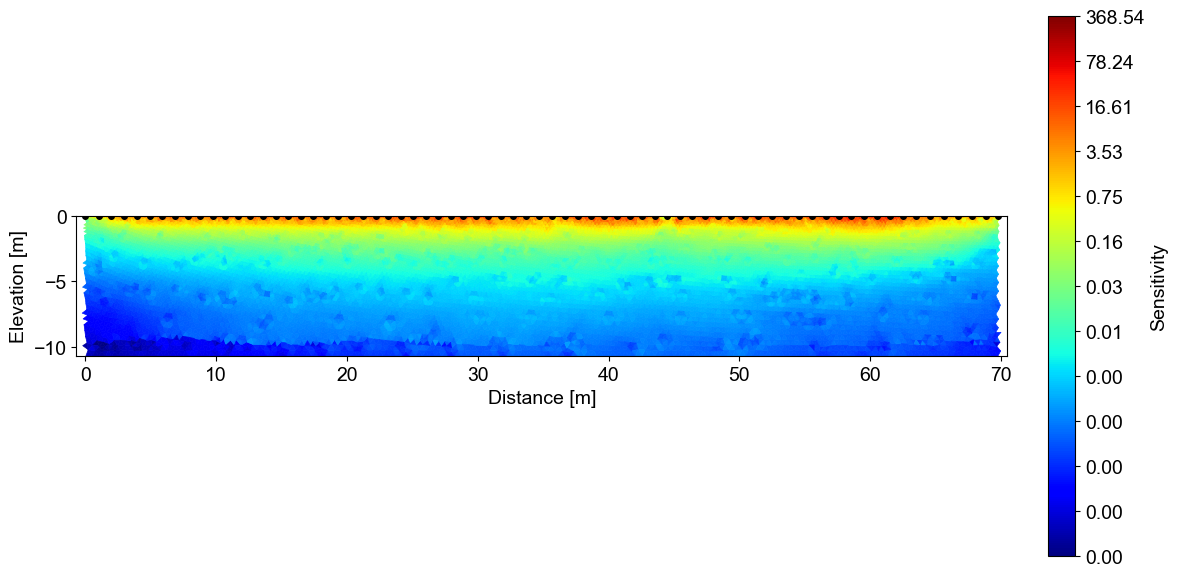

In [9]:
k.param['max_iter'] = 5

k.param['a_wgt'] = 0.01
k.param['b_wgt'] = 0.05

k.param['reg_mode'] = 1
k.param['alpha_s'] = 0.005

k.invert(modErr=True, pseudoStart=False)
k.showInvError()

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
fig, ax2 = plt.subplots(1, 1, figsize=(12, 6))
k.showResults(ax=ax1, attr='Conductivity(mS/m)', vmin=10, vmax = 500, color_map='plasma', sens=False)
k.showResults(ax=ax2, attr='Sensitivity(log10)', color_map='jet', sens=False)

In [16]:
#%% 2D Profile Visualziations

## Paths to Files
ERTnc =  pd.read_fwf(datDir + 'va_ag_invResult.dat', sep=' ', header=None, names=['X', 'Z', 'Resistivity(ohm.m)', 'Resistivity(log10)'], skipinitialspace=True)
ERTnc['Conductivity(mS/m)'] = (1/ERTnc['Resistivity(ohm.m)'])*1000
EMIcal = pd.read_csv(datDir + eminame)
ERTc = pd.read_fwf(datDir + 'invdir\\f001_res.dat', sep=' ', header=None, names=['X', 'Z', 'Resistivity(ohm.m)', 'Resistivity(log10)'], skipinitialspace=True)
ERTc['Conductivity(mS/m)'] = (1/ERTc['Resistivity(ohm.m)'])*1000
xyData_UTM1 = direct_local_grid_to_utm_along_line(ERTnc, pd.read_csv(datDir + elecname), polyDeg=10, lineLength=71, correctCoords=False, checkLine=False, saveElec=False, elecPath=None)  # Run function
xyData_UTM2 = direct_local_grid_to_utm_along_line(ERTc, pd.read_csv(datDir + elecname), polyDeg=10, lineLength=71, correctCoords=False, checkLine=False, saveElec=False, elecPath=None)  # Run function


dflist = [EMIcal, xyData_UTM2] # Names of variables that will be mapped to ERI line
dfnames = ['emi', 'informed'] # Names for each entry in dflist that will be used in the column headers for the combined dataframe
for df in dflist:
    df.rename(columns={'Depth': 'Z'}, inplace=True)
EMIcal.rename(columns={'Depth': 'Z'}, inplace=True)

# xyData_UTM2.rename(columns={'Resistivity(ohm.m)': 'informed_Resistivity(ohm.m)',
#                      'Resistivity(log10)': 'informed_Resistivity(log10)',
#                      'Conductivity(mS/m)': 'informed_Conductivity(mS/m)'}, inplace=True)
# ERTcomb = pd.concat([xyData_UTM, ERTc.iloc[:, 3:6]], axis=1)

mapper = er2em.DataMapper(num_neighbors=1, max_distance_xy=3, max_distance_z = 0.25, ckdMethod='num')   # Initiates testcalib.py. Adjust parameters as needed

result_xy, distances_xy = mapper.mapXYZ(xyData_UTM1, dflist, dfnames) # Maps entries in dflist to EMIcal

# result_xy['Z']  *= -1

for i in range(0, len(result_xy)):
    if result_xy.loc[i, 'Z'] < result_xy.loc[i, 'emi_DOI']:
        result_xy.loc[i, 'emi_DOI Flag'] = 1
    else:
        result_xy.loc[i, 'emi_DOI Flag'] = 0

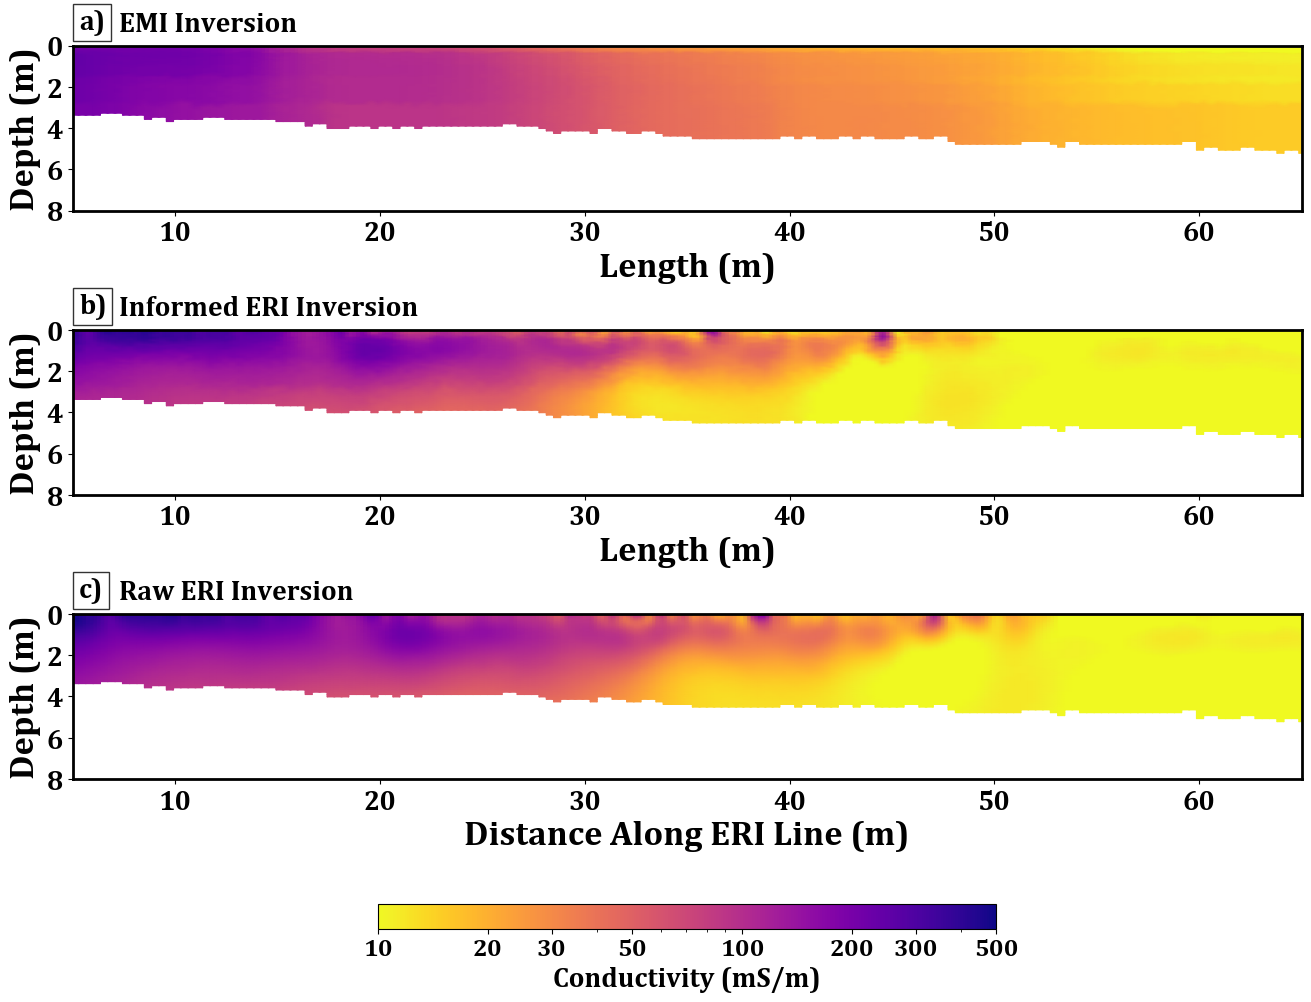

In [19]:
#%% Plot Contours for Each Survey

# Define font parameters
plt.rcParams['font.family'] = 'Cambria'
plt.rcParams['font.weight'] = 'bold'

# Define vmin and vmax for contour plots
vmin, vmax = 10, 500  # Define Colorbar Limits
xlim_min, xlim_max = 5, 65  # Define Range of x-values in Plots
color_map = "plasma_r"   # Define colormap
num_ticks = 5   # Define number of ticks in colorbar
contourSmooth = 'smooth'   # 'smooth' for smoothed plots, 'contour' for contour plots
zBounds = [0, 8]   # Define depth bounds for plots
numZticks = 5   # Define number of ticks for depth axis
exportJointCsv = True  # If True, export result_xy as a .csv file with all rows with nan removed
csvDir = r'C:\Users\Chris\Downloads\\'    # Path to export Joint CSV file to

# Generate log-spaced values between log10 min and max
ticks = [10, 20, 30, 50, 100, 200, 300, 500]

# Figure with 3 subplots, making the KDE plot thinner
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13, 10), constrained_layout=True,
                         gridspec_kw={'height_ratios': [4, 4, 4]})  # Top KDE plot is thin

sf1 = 'a)'
sf2 = 'b)'
sf3 = 'c)'
sf4 = r'EMI Inversion'
sf5 = r'Informed ERI Inversion'
sf6 = r'Raw ERI Inversion'

plot_contour(axes[0], result_xy['X'], -1*result_xy['Z'],
             result_xy['emi_Linear Conductivity'], vmin, vmax,
             '', xlim_min, xlim_max, cmap=color_map, cbbool=False, cbLabel='Conductivity (mS/m)', cbTicks=ticks, ri=result_xy['emi_DOI Flag'], riThresh=1, dist=False, subfig=sf1, subfig2=sf4, zbounds=zBounds, numZtick=numZticks, contourOrSmooth=contourSmooth, plotMeas=False)

plot_contour(axes[1], result_xy['X'], -1*result_xy['Z'],
             result_xy['informed_Conductivity(mS/m)'], vmin, vmax,
             '', xlim_min, xlim_max, cmap=color_map, cbbool=False, cbLabel='Conductivity (mS/m)', cbTicks=ticks, ri=result_xy['emi_DOI Flag'], riThresh=1, dist=False, subfig=sf2, subfig2=sf5, zbounds=zBounds, numZtick=numZticks, contourOrSmooth=contourSmooth, plotMeas=False)

plot_contour(axes[2], result_xy['X'], -1*result_xy['Z'],
             result_xy['Conductivity(mS/m)'], vmin, vmax,
             '', xlim_min, xlim_max, cmap=color_map, cbbool=True, cbLabel='Conductivity (mS/m)', cbTicks=ticks, ri=result_xy['emi_DOI Flag'], riThresh=1,  dist=True, subfig=sf3, subfig2=sf6, zbounds=zBounds, numZtick=numZticks, contourOrSmooth=contourSmooth, plotMeas=False)

# Save and display
plt.savefig(datDir + 'combined_eri_infEMI_ncEMI_plot.png', dpi=300, format='png')
plt.show()

if exportJointCsv:
    trim_result = result_xy.copy(deep=True)
    # trim_result.dropna(inplace=True, subset=['cal_Linear Conductivity_geom', 'nc_Linear Conductivity_geom'])
    trim_result.to_csv(datDir + 'EMI_calERI_ncERI_df.csv', index=False)


             Informed (ERI vs EMI)  Raw (ERI vs EMI)
KGE_np                        0.89              0.91
KGE_2009                      0.69              0.72
KGE_2012                      0.63              0.70
NSE                           0.73              0.77
R²                            0.89              0.89
Pearson r                     0.94              0.94
Spearman r                    0.92              0.92
ME                           -0.08             -0.03
MAE                           0.19              0.17
RMSE                          0.23              0.21
NRMSE_range                   0.15              0.14


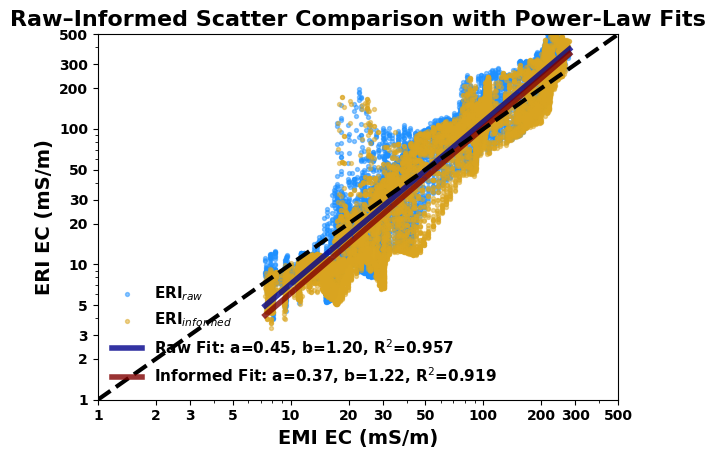

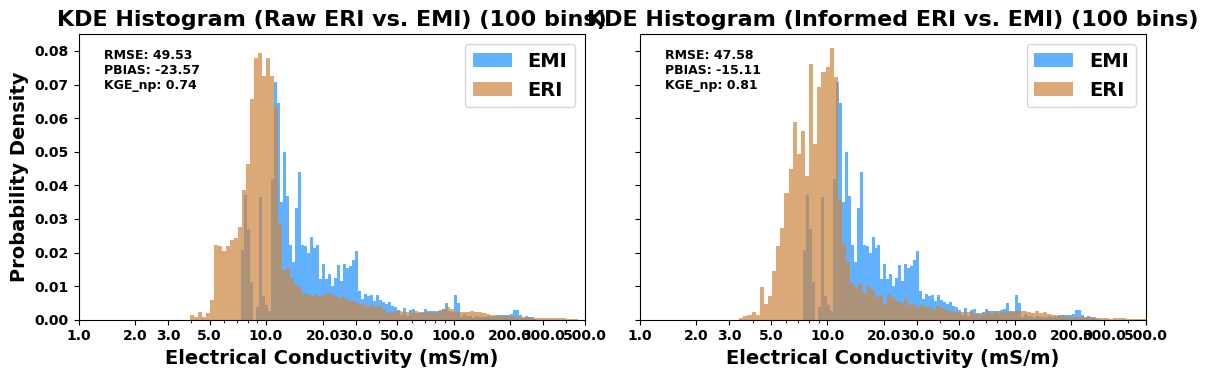

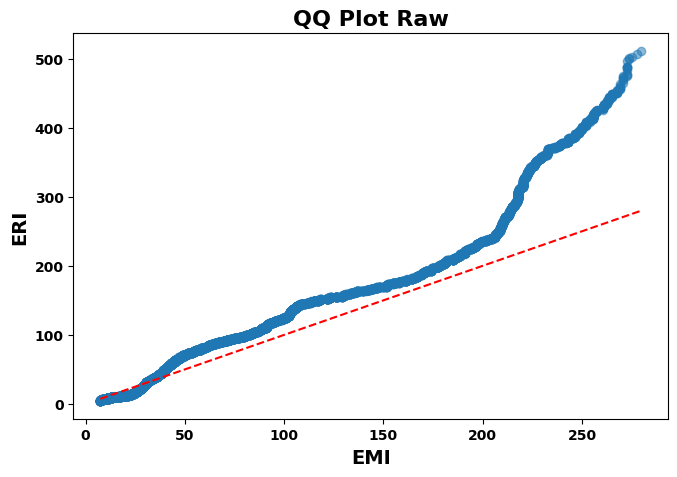

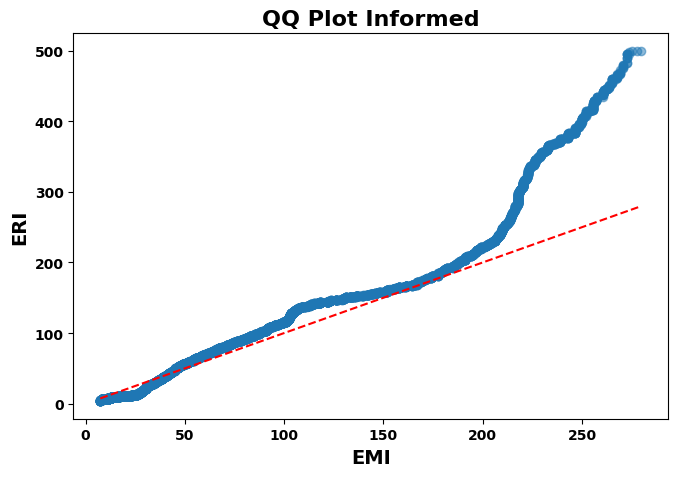

C:\Users\Chris\Box\Rutgers Stuff\Research\EM_ERI Calibration Paper\EConflux\examples\va_ag_em2er\..\..\code\vse.py:456: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


{'Mean difference': 16.089, 'Std. deviation': 46.847, 'Upper 95% limit': 107.909, 'Lower 95% limit': -75.732, 'Ratio range': '0.00× – 73175577897379662155844242775879204291251011584.00× ER'}
{'Mean difference': 10.318, 'Std. deviation': 46.443, 'Upper 95% limit': 101.346, 'Lower 95% limit': -80.71, 'Ratio range': '0.00× – 103281541019643100330270743022811960563466240.00× ER'}


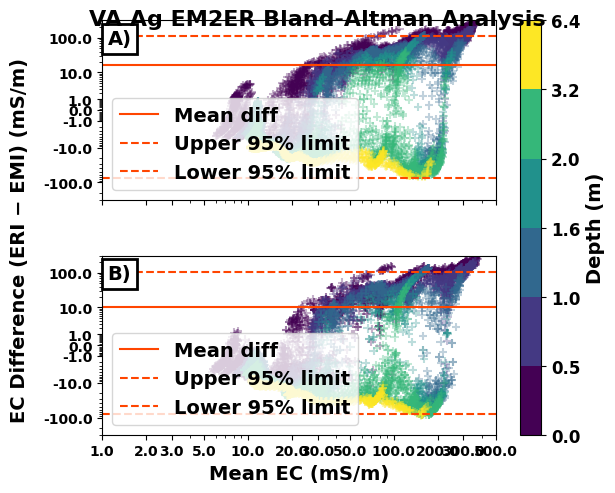

In [23]:
#%% Statistical Analysis

site = 'va_ag'  # Site shorthand to use for file naming

figdir = datDir #  Directory where the figures will be saved to

ticks = [1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300, 500]   # Ticks to be used for all EC axes

logList = [1, 1]   # List dictating whether to use log (1) or linear (0) scales for the Bland-Altman plots

fontkwDict = {'fontfamily': 'sans-serif',
              'fontweight': 'bold',
              'titlefontsize': titleFontKws['fontsize'],
              'titlefontweight': titleFontKws['fontweight'],
              'axislabelsize': labelFontKws['fontsize'],
              'axislabelweight': labelFontKws['fontweight'],
              'axisticksize': tickLabelFontKws['labelsize'],
              'cbartitlesize': cbarTitleKws['fontsize'],
              'cbartitleweight': cbarTitleKws['fontweight'],
              'cbarticklabelsize': cbarTickKws['fontsize']}

j = vse.EConfluxStats(datDir + 'EMI_calERI_ncERI_df.csv', 'emi_Linear Conductivity', 'Conductivity(mS/m)', 'informed_Conductivity(mS/m)', drop_flag_col='emi_DOI Flag', 
             informingMethod='EMI', informedMethod='ERI', units='mS/m', ticks=ticks, **fontkwDict)

# Get metrics table
print(j.metrics(logOrlin='log'))

# Make plots

dbounds = [0, 0.5, 1.0, 1.6, 2.0, 3.2, 6.4]
cmap = 'viridis'

j.scatter_plots(log=True, grayscale=False, figname=figdir + site + '_scatter.png')

j.kde_histograms(figname=figdir + site + '_kde.png', nbins=100)

j.qq_plot(j.X, j.y, xlabel="EM", ylabel="Raw ER", title="QQ Plot Raw", figname=figdir + site + '_rawQQ.png')

j.qq_plot(j.X, j.Y, xlabel="EM", ylabel="Informed ER", title="QQ Plot Informed", figname=figdir + site + '_infQQ.png')

### Bland-Altman Plots ###
fig, axs = plt.subplots(2, 1, sharex=True, layout='constrained')

# Bland-Altman for raw EM vs ER
raw_ba = j.bland_altman(j.y, j.X, ax=axs[0], ymin=-300, ymax=300, xmin=None, xmax=None, figname=None, cbar=False, dcolor=True, dbnds=dbounds, dcmap=cmap, xticks=ticks, logList=logList, legendParams={'plot': True, 'loc': 'lower left'})
print(raw_ba)

# Bland-Altman for informed EM vs ER
informed_ba = j.bland_altman(j.Y, j.X, ax=axs[1], ymin=-300, ymax=300, xmin=None, xmax=None, figname=None, cbar=False, dcolor=True, dcmap=cmap, dbnds=dbounds, xticks=ticks, logList=logList, legendParams={'plot': True, 'loc': 'lower left'}, savefig=False)
print(informed_ba)

# Bland-Altman plot detailing
if dbounds is not None:
    if plt.get_cmap(cmap).N == 256:
        dcmap = plt.get_cmap(cmap, len(dbounds))
    norm = colors.BoundaryNorm(dbounds, ncolors=len(dbounds))
else:
    norm = colors.Normalize(vmin=0, vmax=abs(j.data['Z'].min()))
            
cmmapable = cm.ScalarMappable(norm, dcmap)

fig.suptitle('VA Ag EM2ER Bland-Altman Analysis', **titleFontKws)
axs[0].set_xlabel('')
axs[0].set_ylabel('')

props = dict(boxstyle='square', facecolor='white', lw=2)
axs[0].text(0.014, 0.95, 'A)', transform=axs[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axs[1].set_ylabel('')
axs[1].text(0.014, 0.95, 'B)', transform=axs[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
fig.supylabel("EC Difference " + f"({j.informedMethod} − {j.informingMethod}) ({j.units})", **labelFontKws)
cb = plt.colorbar(cmmapable, ax=axs[:], location='right', orientation='vertical', boundaries=dbounds)
cb.set_label('Depth (m)', **j.cbarTitleKws)
cb.ax.tick_params(axis='y', labelsize=j.cbarTickKws['fontsize'])

plt.savefig(figdir + site + '_blandaltman.png', dpi=300)